<a href="https://colab.research.google.com/github/kirtirajput13/synthetic-breast-cancer-data-creation/blob/main/synthetic_data_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted to /content/extracted_files
Loaded mdb263lm.pgm with shape: (2048, 4320)
Loaded mdb109ll.pgm with shape: (2600, 4320)
Loaded mdb044rs.pgm with shape: (1600, 4320)
Loaded mdb258rl.pgm with shape: (2600, 4320)
Loaded mdb206rl.pgm with shape: (2600, 4320)
Loaded mdb058rl.pgm with shape: (2600, 4320)
Loaded mdb265lm.pgm with shape: (2048, 4320)
Loaded mdb008rl.pgm with shape: (2600, 4320)
Loaded mdb013ll.pgm with shape: (2600, 4320)
Loaded mdb227lm.pgm with shape: (2048, 4320)
Loaded mdb242rs.pgm with shape: (1600, 4320)
Loaded mdb214rs.pgm with shape: (1600, 4320)
Loaded mdb085lm.pgm with shape: (2048, 4320)
Loaded mdb113ls.pgm with shape: (1600, 4320)
Loaded mdb127lm.pgm with shape: (2048, 4320)
Loaded mdb291ll.pgm with shape: (2600, 4320)
Loaded mdb041ll.pgm with shape: (2600, 4320)
Loaded mdb166rs.pgm with shape: (1600, 4320)
Loaded mdb035ls.p

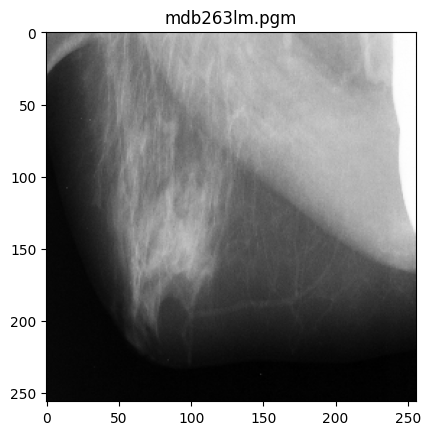

Loaded 322 images with shape: (256, 256)
Epoch 1/10
9/9 [==============================] - 1005s 110s/step - loss: 0.4142 - accuracy: 0.9105 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
9/9 [==============================] - 999s 110s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
9/9 [==============================] - 990s 110s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
9/9 [==============================] - 975s 108s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
9/9 [==============================] - 980s 108s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
2/9 [=====>........................] - ETA: 13:22 - loss: 0.0000e+00 - accuracy: 1.0000

In [ ]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG19
import matplotlib.pyplot as plt

# Mount Google Drive and extract files
def mount_drive_and_extract(zip_path, extract_path):
    from google.colab import drive
    drive.mount('/content/drive')
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f'Files extracted to {extract_path}')

# Load PGM images
def load_pgm_images(mias_path, image_size):
    pgm_files = [f for f in os.listdir(mias_path) if f.endswith('.pgm')]
    images = []
    for file in pgm_files:
        img_path = os.path.join(mias_path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: {file} could not be read.")
            continue
        print(f"Loaded {file} with shape: {img.shape}")
        img_resized = cv2.resize(img, image_size)
        images.append(img_resized)
    images = np.array(images)
    return images, pgm_files

# Display a sample image
def display_sample_image(images, pgm_files):
    plt.imshow(images[0], cmap='gray')
    plt.title(pgm_files[0])
    plt.show()
    print(f"Loaded {len(images)} images with shape: {images[0].shape}")

# Parse label from dataset
def parse_label(labels_df, reference_number):
    row = labels_df[labels_df['reference'] == reference_number]
    if not row.empty:
        abnormality_class = row.iloc[0]['abnormality']
        severity = row.iloc[0]['severity']
        if pd.isna(abnormality_class) or pd.isna(severity):
            return 6  # NORM
        return {
            'CALC': 0,
            'CIRC': 1,
            'SPIC': 2,
            'MISC': 3,
            'ARCH': 4,
            'ASYM': 5
        }.get(abnormality_class, 6)
    return 6

# Load images and labels
def load_images_and_labels(dataset_path, labels_file_path, image_size, num_classes):
    labels_df = pd.read_csv(labels_file_path, sep=' ', header=None,
                            names=['reference', 'background', 'abnormality', 'severity', 'x', 'y', 'radius'], na_values=[''])
    images, labels = [], []
    for filename in os.listdir(dataset_path):
        if filename.endswith('.pgm'):
            reference_number = filename.split('.')[0]
            image_path = os.path.join(dataset_path, filename)
            image = load_img(image_path, color_mode='rgb', target_size=image_size)
            image = img_to_array(image)
            images.append(image)
            label = parse_label(labels_df, reference_number)
            labels.append(label)
    images = np.array(images, dtype=np.float32) / 255.0
    labels = to_categorical(np.array(labels, dtype=np.int32), num_classes=num_classes)
    return images, labels

# Data augmentation
def augment_images(images, labels):
    data_gen_args = dict(rotation_range=10.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2,
                         horizontal_flip=True)
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    label_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    label_datagen.fit(labels, augment=True, seed=seed)
    return image_datagen, label_datagen

# Fine-tune VGG19 for perceptual loss
def fine_tune_vgg19(train_dataset, val_dataset, image_shape, num_classes):
    base_model = VGG19(include_top=False, input_shape=image_shape, pooling='avg')
    base_model.trainable = True  # Enable training for fine-tuning

    model = tf.keras.Sequential([
        base_model,
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_dataset, epochs=10, validation_data=val_dataset)
    return tf.keras.Model(inputs=base_model.input, outputs=base_model.output)

# Calculate class weights for cost-sensitive learning
def compute_class_weights(labels):
    y_integers = np.argmax(labels, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
    return tf.convert_to_tensor(class_weights, dtype=tf.float32)  # Convert to tensor

# Custom discriminator loss with class weights
def weighted_discriminator_loss(real_logits, fake_logits, real_labels, class_weights):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_logits), real_logits, from_logits=True)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_logits), fake_logits, from_logits=True)
    class_weight_vector = tf.gather(class_weights, tf.argmax(real_labels, axis=1))
    weighted_real_loss = real_loss * class_weight_vector
    weighted_fake_loss = fake_loss * class_weight_vector
    return tf.reduce_mean(weighted_real_loss + weighted_fake_loss)

# Build generator model
def build_generator(latent_dim, num_classes, image_shape):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(num_classes,))
    model_input = layers.Concatenate()([noise, label])
    x = layers.Dense(128 * (image_shape[0] // 4) * (image_shape[1] // 4))(model_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape((image_shape[0] // 4, image_shape[1] // 4, 128))(x)
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(3, kernel_size=7, activation='tanh', padding='same')(x)
    return Model([noise, label], x)

# Build discriminator model with spectral normalization
def build_discriminator(image_shape, num_classes):
    def spectral_norm(layer):
        return tf.keras.layers.BatchNormalization()(layer)  # Updated to BatchNormalization

    image = layers.Input(shape=image_shape)
    label = layers.Input(shape=(num_classes,))
    label_embedding = layers.Dense(np.prod(image_shape))(label)
    label_embedding = layers.Reshape(image_shape)(label_embedding)
    concatenated = layers.Concatenate(axis=-1)([image, label_embedding])
    x = spectral_norm(layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(concatenated))
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = spectral_norm(layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x))
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1)(x)
    return Model([image, label], x)

# Adaptive WGAN-GP model
class AdaptiveWGAN_GP(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, num_classes, discriminator_extra_steps=3, initial_gp_weight=10.0, perceptual_weight=0.1):
        super(AdaptiveWGAN_GP, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.d_steps = discriminator_extra_steps
        self.initial_gp_weight = initial_gp_weight
        self.perceptual_weight = perceptual_weight
        self.epoch = 0

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, perceptual_model):
        super(AdaptiveWGAN_GP, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.perceptual_model = perceptual_model

    def adaptive_gradient_penalty(self, batch_size, real_images, fake_images, labels):
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            validity_interpolated = self.discriminator([interpolated, labels])
        grads = gp_tape.gradient(validity_interpolated, [interpolated])[0]
        grads = tf.reshape(grads, [tf.shape(grads)[0], -1])
        norm = tf.norm(grads, axis=1)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        scaling_factor = 1.0 + tf.math.log(1.0 + tf.cast(self.epoch, tf.float32))
        return self.initial_gp_weight * gp * scaling_factor

    def train_step(self, real_data):
        real_images, real_labels = real_data
        batch_size = tf.shape(real_images)[0]

        for _ in range(self.d_steps):
            random_latent_vectors = tf.random.normal([batch_size, self.latent_dim])
            fake_images = self.generator([random_latent_vectors, real_labels])
            with tf.GradientTape() as tape:
                real_logits = self.discriminator([real_images, real_labels])
                fake_logits = self.discriminator([fake_images, real_labels])
                d_cost = self.d_loss_fn(real_logits, fake_logits)
                gp = self.adaptive_gradient_penalty(batch_size, real_images, fake_images, real_labels)
                d_loss = d_cost + gp
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal([batch_size, self.latent_dim])
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, real_labels])
            fake_logits = self.discriminator([generated_images, real_labels])
            g_loss = self.g_loss_fn(misleading_labels, fake_logits)
            perceptual = self.perceptual_weight * perceptual_loss(self.perceptual_model, real_images, generated_images)
            g_loss += perceptual
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        self.epoch += 1
        return {"d_loss": d_loss, "g_loss": g_loss}

    def call(self, inputs):
        pass

# Perceptual loss using VGG19
def perceptual_loss(perceptual_model, real_images, fake_images):
    real_features = perceptual_model(real_images)
    fake_features = perceptual_model(fake_images)
    return tf.reduce_mean(tf.square(real_features - fake_features))

# Paths and parameters
zip_path = '/content/drive/MyDrive/miasdbv1.21.zip'
extract_path = '/content/extracted_files'
dataset_path = os.path.join(extract_path, 'MIASDBv1.21')
labels_file_path = '/content/Info.txt'
image_size = (256, 256)
batch_size = 32
latent_dim = 100
num_classes = 7
image_shape = (256, 256, 3)

# Extract files
mount_drive_and_extract(zip_path, extract_path)

# Load and display images
images, pgm_files = load_pgm_images(dataset_path, image_size)
display_sample_image(images, pgm_files)

# Load dataset
images, labels = load_images_and_labels(dataset_path, labels_file_path, image_size, num_classes)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Fine-tune the VGG19 model
perceptual_model = fine_tune_vgg19(train_dataset, val_dataset, image_shape, num_classes)
perceptual_model.trainable = False  # Freeze the weights after fine-tuning

# Initialize models
generator = build_generator(latent_dim, num_classes, image_shape)
discriminator = build_discriminator(image_shape, num_classes)

# Optimizers and loss functions
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
class_weights = compute_class_weights(y_train)
d_loss_fn = lambda real, fake: weighted_discriminator_loss(real, fake, y_train, class_weights)
g_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Compile and train the model with the modified loss function
wgan = AdaptiveWGAN_GP(discriminator, generator, latent_dim, num_classes, perceptual_weight=0.1)
wgan.compile(d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, perceptual_model)
wgan.fit(train_dataset, epochs=100, validation_data=val_dataset)
